### What is the prediction performance of AR features using Logistic Regression and Linear SVM?

In [1]:
import numpy as np
import mne
from tqdm import tqdm
from ARMA import ARMA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, auc, precision_recall_curve, \
                            classification_report, confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.plotting import parallel_coordinates

In [2]:
root = '/Volumes/My Passport/AI_Research/data/physionet.org/files/chbmit/1.0.0/' 
case = 'chb01/'
preictal_filenames = ['chb01_03_preictal.npy', 'chb01_04_preictal.npy', 'chb01_15_preictal.npy', 'chb01_16_preictal.npy',
             'chb01_18_preictal.npy', 'chb01_26_preictal.npy']
interictal_filenames = ['chb01_01.edf', 'chb01_02.edf', 'chb01_05.edf',
                        'chb01_06.edf', 'chb01_07.edf', 'chb01_08.edf']

In [3]:
def load_EEG(filepath, label) -> (np.ndarray, np.ndarray):
    if label == 'preictal':
        data = np.load(filepath)
        target = np.ones(data.shape[1])
    if label == 'interictal':
        data = mne.io \
        .read_raw_edf(input_fname=filepath, preload=False, verbose='Error') \
        .get_data(picks='all', units='uV', return_times=False)
        target = -1 * np.ones(data.shape[1])
    return data, target

In [4]:
# ARMA parameters
seed = 42
fs = 256                 # sampling frequency (Hz)
N = 512                  # fs = N*fp (N must be a natural number)
fp = fs/N                # prediction frequency
n_i = 2                  # AR model order
t_s = 1/fs               # Input signal time period
n_c = 23                 # Number of EEG electrodes (channels)
m = 30                   # MA parameter
print(f'Input channels: {n_c}')
print(f'Model: AR({n_i})')
print(f'MA lookback: {m}')
print(f'Window size: {N}')
print(f'Sampling frequency: {fs} Hz')
print(f'Prediction frequency: {fp} Hz')
ar = ARMA(window_width=N, order=n_i, memory=m, seed=seed)

Input channels: 23
Model: AR(2)
MA lookback: 30
Window size: 512
Sampling frequency: 256 Hz
Prediction frequency: 0.5 Hz


In [5]:
# load preictal and interictal data
preictal_feature_list = []
interictal_feature_list = []
for i in range(6):
    # load preictal data
    p_filepath = root + case + preictal_filenames[i]
    p_data, _ = load_EEG(p_filepath, 'preictal')
    # generate preictal features
    _, _, preictal_features = ar.spin(sig=p_data, fs=256)
    # load interictal data
    ic_filepath = root + case + interictal_filenames[i]
    ic_data, _ = load_EEG(ic_filepath, 'interictal')
    # generate interictal features
    _, _, interictal_features = ar.spin(sig=ic_data[:,:p_data.shape[1]], fs=256)
    
    # store data in list
    preictal_feature_list.append(preictal_features)
    interictal_feature_list.append(interictal_features)

100%|██████████| 229887/229887 [00:03<00:00, 59948.61it/s]


In [32]:
preictal_1 = preictal_feature_list[0][448,:,:]
interictal_1 = interictal_feature_list[0][448,:,:]
preictal_1_targets = np.ones(preictal_feature_list[0][448,:,:].shape[0])
interictal_1_targets = -1 * np.ones(interictal_feature_list[0][448,:,:].shape[0])
joined_1 = np.concatenate((interictal_1, preictal_1), axis=0)
joined_1_targets = np.concatenate((interictal_1_targets, preictal_1_targets))

preictal_2 = preictal_feature_list[1][448,:,:]
interictal_2 = interictal_feature_list[1][448,:,:]
preictal_2_targets = np.ones(preictal_feature_list[1][448,:,:].shape[0])
interictal_2_targets = -1 * np.ones(interictal_feature_list[1][448,:,:].shape[0])
joined_2 = np.concatenate((interictal_2, preictal_2), axis=0)
joined_2_targets = np.concatenate((interictal_2_targets, preictal_2_targets))

double_joined = np.concatenate((joined_1, joined_2), axis=0)
double_joined_targets = np.hstack((joined_1_targets, joined_2_targets))
print(double_joined.shape, double_joined_targets.shape)

(92, 2) (92,)


### Logistic Regression

[[3 2]
 [0 5]]
              precision    recall  f1-score   support

        -1.0       1.00      0.60      0.75         5
         1.0       0.71      1.00      0.83         5

    accuracy                           0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10



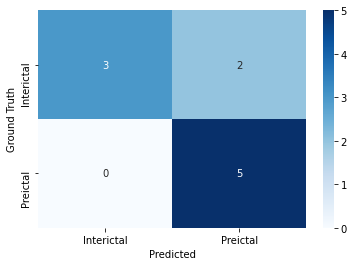

In [33]:
X_train, X_test, y_train, y_test = train_test_split(double_joined, double_joined_targets, test_size=0.10, random_state=42)
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
confuse = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confuse, annot=True, cmap='Blues')
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.show()

[[3 2]
 [0 5]]
              precision    recall  f1-score   support

        -1.0       1.00      0.60      0.75         5
         1.0       0.71      1.00      0.83         5

    accuracy                           0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10



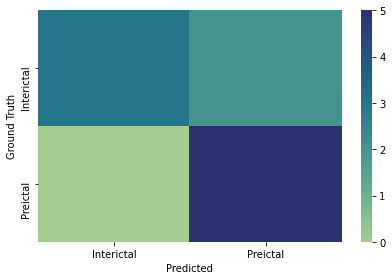

In [49]:
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
confuse = confusion_matrix(y_test, y_pred)
palette = sns.color_palette("crest", as_cmap=True)
ax = sns.heatmap(confuse, cmap=palette)
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.tight_layout()
plt.savefig('../figures/feature_extraction/chb001/AR_SVM_heatmap.pdf')
plt.show()

[[5 0]
 [0 5]]
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00         5
         1.0       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



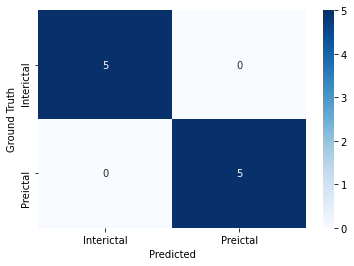

In [35]:
svc = SVC(kernel='rbf')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
confuse = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(confuse, annot=True, cmap='Blues')
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.show()